In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [4]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
def get_std_scaled(df=None):
    df_copy = df.copy()
    std_scaler = StandardScaler()
    df_copy = std_scaler.fit_transform(df_copy)
    return df_copy

def get_minmax_scaled(df=None):
    df_copy = df.copy()
    std_scaler = MinMaxScaler()
    df_copy = std_scaler.fit_transform(df_copy)
    return df_copy

In [7]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'macro')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, macro f1_score: {3:.4f}'.format(accuracy, precision, recall, f1))

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/train_smote.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/val.csv')
valid_df.drop(['ID'], axis=1, inplace=True)
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_df.drop(['ID'], axis=1, inplace=True)
print(train_df.shape, valid_df.shape, test_df.shape)
print('train_smote data 이상치 비율:', train_df[train_df['Class'] == 1].shape[0] / train_df.shape[0])
print('valid data 이상치 비율:', valid_df[valid_df['Class'] == 1].shape[0] / valid_df.shape[0])

(227500, 31) (28462, 31) (142503, 30)
train_smote data 이상치 비율: 0.5
valid data 이상치 비율: 0.0010540369615627855


In [9]:
train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972,0
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972,0
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960,0
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901,0
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901,0


In [10]:
valid_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [11]:
test_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [12]:
X_train, y_train, X_valid, y_valid = train_df.iloc[:, :-1], train_df['Class'], valid_df.iloc[:, :-1], valid_df['Class']

In [13]:
xgb_clf = XGBClassifier(n_estimators=2000, max_depth=6, subsample=0.5, learning_rate=0.1, objective='binary:logistic', tree_method='gpu_hist', gpu_id=0, random_state=0)

In [14]:
xgb_clf.fit(X_train, y_train, early_stopping_rounds=500, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse')

[0]	validation_0-rmse:0.450196	validation_1-rmse:0.450219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:0.405731	validation_1-rmse:0.405777
[2]	validation_0-rmse:0.365916	validation_1-rmse:0.365993
[3]	validation_0-rmse:0.330185	validation_1-rmse:0.330295
[4]	validation_0-rmse:0.298072	validation_1-rmse:0.298225
[5]	validation_0-rmse:0.269183	validation_1-rmse:0.269376
[6]	validation_0-rmse:0.24317	validation_1-rmse:0.24341
[7]	validation_0-rmse:0.219726	validation_1-rmse:0.220019
[8]	validation_0-rmse:0.198591	validation_1-rmse:0.19894
[9]	validation_0-rmse:0.179525	validation_1-rmse:0.179937
[10]	validation_0-rmse:0.162325	validation_1-rmse:0.162807
[11]	validation_0-rmse:0.146791	validation_1-rmse:0.147356
[12]	validation_0-rmse:0.132776	validation_1-rmse:0.133417
[13]	validation_0-rmse:0.120127	validation_1-rmse:0.120866
[14]	validation_0-rmse:0.10

XGBClassifier(gpu_id=0, max_depth=6, n_estimators=2000, subsample=0.5,
              tree_method='gpu_hist')

In [15]:
pred_valid = xgb_clf.predict(X_valid)

In [16]:
get_clf_eval(y_valid, pred_valid)

오차 행렬
[[28430     2]
 [    7    23]]
정확도: 0.9997, 정밀도: 0.9200, 재현율: 0.7667, macro f1_score: 0.9181


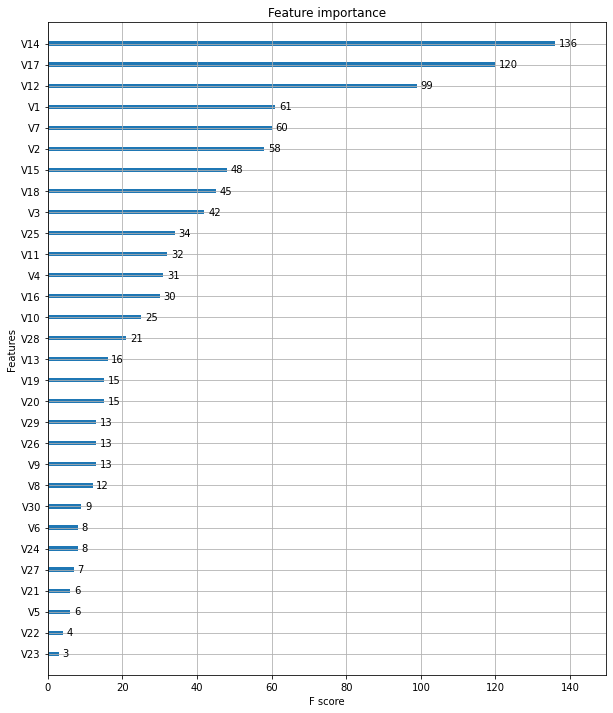

In [17]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf, ax=ax)

In [18]:
pred_test = xgb_clf.predict(test_df)

In [19]:
valid_pred_df = pd.DataFrame(np.concatenate((valid_df.iloc[:, :-1].values, pred_valid.reshape(-1, 1)), axis=1), columns = valid_df.columns)
valid_pred_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0.0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0.0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0.0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0.0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0.0


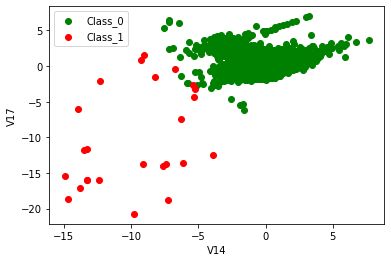

In [21]:
plt.scatter(valid_pred_df[valid_pred_df['Class']==0].V14, valid_pred_df[valid_pred_df['Class']==0].V17, color='green', label= 'Class_0')
plt.scatter(valid_pred_df[valid_pred_df['Class']==1].V14, valid_pred_df[valid_pred_df['Class']==1].V17, color='red', label= 'Class_1')
plt.xlabel('V14')
plt.ylabel('V17')
plt.legend()
plt.show()

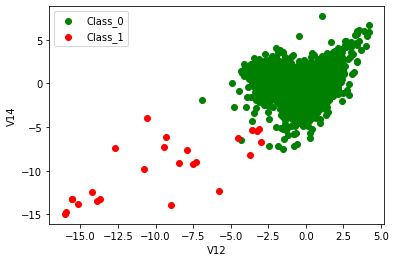

In [22]:
plt.scatter(valid_pred_df[valid_pred_df['Class']==0].V12, valid_pred_df[valid_pred_df['Class']==0].V14, color='green', label= 'Class_0')
plt.scatter(valid_pred_df[valid_pred_df['Class']==1].V12, valid_pred_df[valid_pred_df['Class']==1].V14, color='red', label= 'Class_1')
plt.xlabel('V12')
plt.ylabel('V14')
plt.legend()
plt.show()

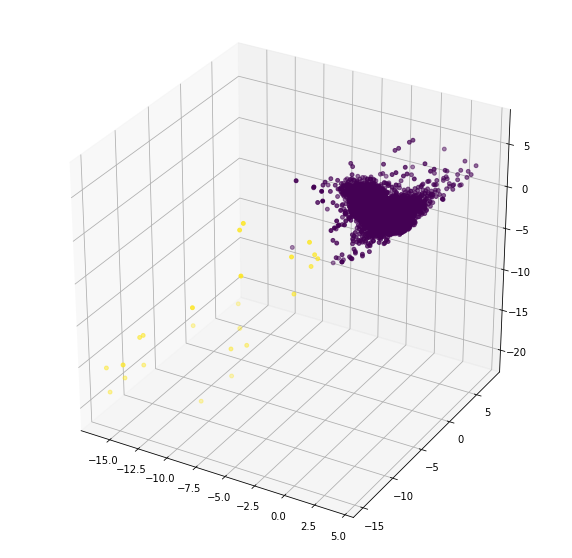

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_pred_df.V12, valid_pred_df.V14, valid_pred_df.V17, c=valid_pred_df.Class, marker='o', s=15)

## GridSearchCV

In [ ]:
params = {'n_estimators' : [3000, 5000], 'max_depth' : [10, 30], 'subsample' : [0.6], 'learning_rate' : [0.05, 0.1], 'gamma' : [0, 20], 'max_bin' : [1024]}

In [ ]:
xgb_clf_gscv = XGBClassifier(objective='binary:logistic', gpu_id=0, tree_method='gpu_hist', random_state=0)
grid_cv = GridSearchCV(xgb_clf_gscv, param_grid=params, scoring='f1_macro', cv=2, verbose=1)
grid_cv.fit(X_train, y_train, early_stopping_rounds=200, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc')
print('최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[0]	validation_0-auc:0.999881	validation_1-auc:0.915827
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.999921	validation_1-auc:0.915854
[2]	validation_0-auc:0.999925	validation_1-auc:0.915842
[3]	validation_0-auc:0.999925	validation_1-auc:0.915842
[4]	validation_0-auc:0.999925	validation_1-auc:0.915856
[5]	validation_0-auc:0.999925	validation_1-auc:0.915856
[6]	validation_0-auc:0.999925	validation_1-auc:0.915856
[7]	validation_0-auc:0.999925	validation_1-auc:0.915803
[8]	validation_0-auc:0.999925	validation_1-auc:0.915803
[9]	validation_0-auc:0.999925	validation_1-auc:0.915799
[10]	validation_0-auc:0.999925	validation_1-auc:0.915799
[11]	validation_0-auc:0.999925	validation_1-auc:0.915799
[12]	validation_0-auc:0.999925	validation_1-auc:0.915799
[13]	validation_0-auc:0.999925	validation_1-auc:0.

In [ ]:
best_clf = grid_cv.best_estimator_
best_pred = best_clf.predict(X_valid)
get_clf_eval(y_valid, best_pred)

In [ ]:
scores_df = pd.DataFrame(grid_cv.cv_results_)
scores_df[['params', 'mean_test_score' 'rank_test_score']].sort_values('rank_test_score').head(20)

## Submission file형태로 변환

In [ ]:
pred_test = best_clf.predict(test_df)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [ ]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_xgboost_2.csv', index = False)